# Qaintellect implementation of the Quantum Approximation Optimization Algorithm (QAOA)

In this example, we implement the optimization of a circuit based on the QAOA algorithm, demonstrated via the Max-Cut problem.

Reference:
- E. Farhi, J. Goldstone, S. Gutmann: "A Quantum Approximate Optimization Algorithm", [arXiv:1411.4028](http://arxiv.org/abs/1411.4028) (2014)

In [1]:
using Qaintessent
using Qaintellect
using LinearAlgebra
using Flux
using IterTools: ncycle

In [2]:
# visualization
using Plots
using LaTeXStrings

## Definition of the optimization problem

The target function
\begin{equation}
C(b) = \sum_{\alpha=1}^m C_{\alpha}(b) \quad \text{with} \quad C_{\alpha}(b) \in \{ 0, {\color{orange}{1}} \}
\end{equation}
should be maximized with respect to bit strings $b = b_{n-1} \dots b_1 b_0$ of length $n$.

We consider _Max-Cut_ as specific example: for a given graph with $n$ vertices and $m$ edges, the task is to partition its vertices into two subsets $\color{blue}{S_0}$ and $\color{green}{S_1}$, such that the number of edges between these subsets is maximized.

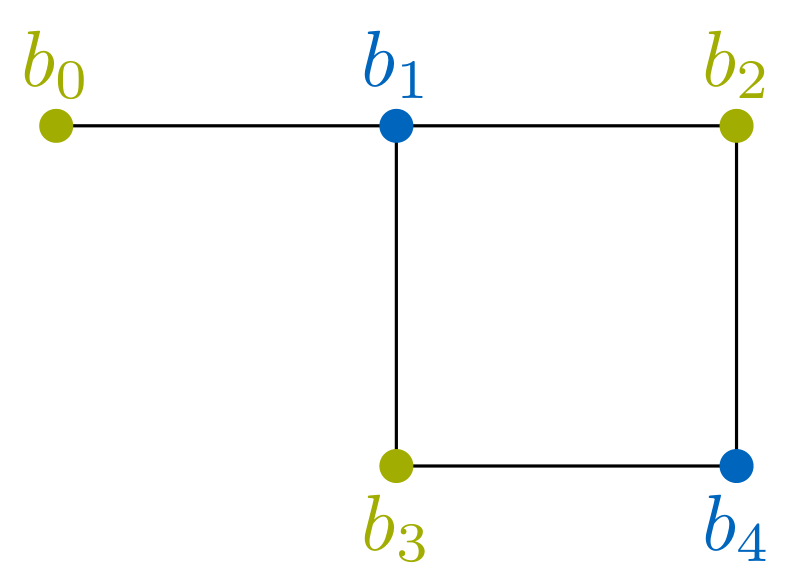

Expressed in terms of the above target function, for $j = 0, 1, \dots, n-1$, the entry $b_j \in \{ \color{blue}{0}, \color{green}{1} \}$ specifies whether the $j$-th vertex belongs to subset $\color{blue}{S_0}$ or $\color{green}{S_1}$. For the $\alpha$-th edge, we define $\mathsf{C}_{\alpha}$ as

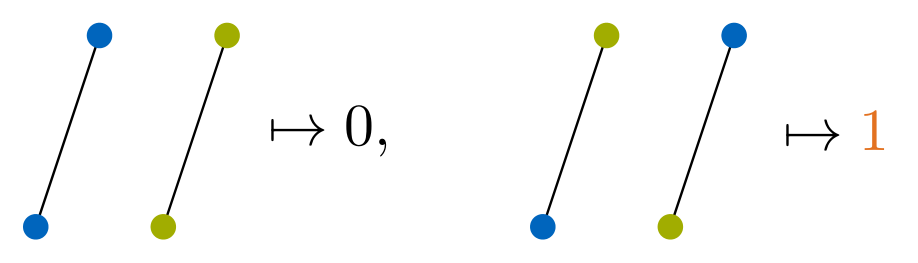

In [3]:
# number of vertices
n = 5

# graph edges corresponding to the above graph
edges = [(0, 1), (1, 2), (1, 3), (2, 4), (3, 4)];

## Quantum formulation and construction of a quantum circuit

Term $C_{\alpha}$ of target function in quantum language:
\begin{equation}
C_{\alpha} = \frac{1}{2} (I - Z_j Z_k),
\end{equation}
with $j$ and $k$ the vertices corresponding to the $\alpha$-th edge in the graph. Each basis state $\lvert b \rangle$ is an eigenvector of $C_{\alpha}$ with eigenvalue $\mathsf{C}_{\alpha}(b)$.

Accordingly, the target function operator reads $C = \sum_{\alpha = 1}^m C_{\alpha}$ (which is diagonal with respect to the standard basis).

The QAOA Ansatz may be motivated by the [adiabatic theorem](https://en.wikipedia.org/wiki/Adiabatic_theorem), stating that a wavefunction remains an instantaneous eigenstate of a Hamiltonian $H(t)$, if $H(t)$ is slowly (adiabatically) changing with time $t$. Here we want to transition from a "simple", easy to construct eigenstate of some operator $B$, to the maximizing eigenstate of the target operator $C$. We setup the transition from $B$ to $C$ as $H(t) = \left(1 - \frac{t}{T}\right) B + \frac{t}{T} C$ for $t \in [0, T]$.

The operator $B$ is chosen as
\begin{equation*}
B = \sum_{j=0}^{n-1} X_j
\end{equation*}
with $X_j$ the Pauli-$X$ matrix acting on qubit $j$.

The largest eigenvalue of $B$ is $n$ (since each $X_j$ in the sum contributes the value $1$). The eigenvector of $B$ corresponding to its largest eigenvalue is the uniform superposition state:
\begin{equation}
\lvert s \rangle = \lvert + \rangle^{\otimes n} = \frac{1}{\sqrt{2^n}} \sum_{b=0}^{2^n - 1} \lvert b \rangle.
\end{equation}

In [4]:
# define uniform superposition state s
s_uni = convert(Vector{ComplexQ}, fill(1/√(2^n) + 0.0im, 2^n));

According to the Schrödinger equation, a time step $\tau$ governed by a time-independent Hamiltonian $H$ is described by the unitary matrix $e^{-i \tau H}$. Even if $H$ slowly changes with time, $e^{-i \tau H(t)}$ is still a good approximation. Together with a splitting approximation for the matrix exponential, $e^{A + B} \approx e^A e^B$ for matrices $A$ and $B$ with small norm, we arrive at $e^{-i \tau H(t)} \approx e^{-i \tau (1 - \frac{t}{T}) B} \, e^{- i \tau \frac{t}{T} C}$ to describe a time step. This motivates the following Ansatz to find the maximizing eigenstate of $C$:
\begin{equation}
\lvert\psi_p(\gamma, \beta)\rangle = e^{-i \beta_p B} e^{-i \gamma_p C} \cdots e^{-i \beta_1 B} e^{-i \gamma_1 C} \lvert s \rangle
\end{equation}
with real parameters $\beta_1, \dots, \beta_p$ and $\gamma_1, \dots, \gamma_p$. The number of "layers" $p$ can be tuned depending on the application.

Note: we simulate the construction of $\lvert\psi_p(\gamma, \beta)\rangle$ here, but this would be performed on an actual quantum computer.

We can represent the unitary time step effected by $C_{\alpha}$ as $e^{-i \gamma C_{\alpha}} = e^{-i \gamma / 2} e^{i \gamma Z_j Z_k / 2}$. The global phase factor $e^{-i \gamma / 2}$ will drop out of the optimization, and the second term is the ZZ-"entanglement" gate.

In [5]:
function assemble_time_step_gates(p::Int, n::Int, edges::Vector{Tuple{Int,Int}})
    cgs = CircuitGate[]
    for _ in 1:p
        # C operator
        for e in edges
            # circuit gate uses 1-based indexing
            push!(cgs, circuit_gate(e[1] + 1, e[2] + 1, EntanglementZZGate(0.01*randn())))
        end
        # B operator
        for j in 1:n
           push!(cgs, circuit_gate(j, RxGate(0.01*randn())))
        end
    end
    return cgs
end

assemble_time_step_gates (generic function with 1 method)

In practice, one performs parameter optimization to maximize the expectation value
\begin{equation}
\langle\psi_p(\gamma, \beta)\rvert C \lvert\psi_p(\gamma, \beta)\rangle,
\end{equation}
such that $\lvert\psi_p(\gamma, \beta)\rangle$ approaches the optimal solution $\lvert b^{\text{opt}} \rangle$ (or a superposition in case there are several optimizers). The preparation of $\lvert\psi_p(\gamma, \beta)\rangle$ and evaluation of the expectation value is to be performed on a quantum computer, and the parameter optimization on a classical computer. A standard measurement of $\lvert\psi_p(\gamma, \beta)\rangle$ then results in $b^{\text{opt}}$ with high probability.

In [6]:
# create measurement operator representing C
Cmat = zeros(2^n, 2^n)
for edge in edges
    k1 = circuit_gate(edge[1] + 1, ZGate())
    k2 = circuit_gate(edge[2] + 1, ZGate())
    Cmat += 0.5*(I - sparse_matrix([k1, k2], n))
end
@show(diag(Cmat))
Cop = MeasurementOperator(Cmat, Tuple(1:n));

diag(Cmat) = ComplexF64[0.0 + 0.0im, 1.0 + 0.0im, 3.0 + 0.0im, 2.0 + 0.0im, 2.0 + 0.0im, 3.0 + 0.0im, 3.0 + 0.0im, 2.0 + 0.0im, 2.0 + 0.0im, 3.0 + 0.0im, 3.0 + 0.0im, 2.0 + 0.0im, 4.0 + 0.0im, 5.0 - 0.0im, 3.0 + 0.0im, 2.0 + 0.0im, 2.0 + 0.0im, 3.0 + 0.0im, 5.0 - 0.0im, 4.0 + 0.0im, 2.0 + 0.0im, 3.0 + 0.0im, 3.0 + 0.0im, 2.0 + 0.0im, 2.0 + 0.0im, 3.0 + 0.0im, 3.0 + 0.0im, 2.0 + 0.0im, 2.0 + 0.0im, 3.0 + 0.0im, 1.0 + 0.0im, 0.0 + 0.0im]


In [7]:
# example
circ = Circuit{n}(assemble_time_step_gates(2, n, edges), [Cop])


    5 ————————————————————□—————□————[Rx]———————————————□—————□————[Rx]—
                          |     |                       |     |         
    4 ——————————————□———————————□————[Rx]—————————□———————————□————[Rx]—
                    |     |                       |     |               
    3 ————————□———————————□————[Rx]—————————□———————————□————[Rx]———————
              |     |                       |     |                     
    2 ——□—————□—————□——————————[Rx]———□—————□—————□——————————[Rx]———————
        |                             |                                 
    1 ——□——————————————————————[Rx]———□——————————————————————[Rx]———————


In [8]:
# example: apply circuit gates and compute expectation value
apply(s_uni, circ)

1-element Vector{Float32}:
 2.499939

## Perform optimization

In [9]:
# first attempt with p = 1

circ1 = Circuit{n}(assemble_time_step_gates(1, n, edges), [Cop])

# gather parameters from circuit
paras = Flux.params(circ1)

# there is not actually any input data for training
data = ncycle([()], 500)

# define optimizer
opt = Descent(0.5)

# define evaluation function
evalcb() = @show(apply(s_uni, circ1))

# perform minimization with the negated target function to achieve maximization
Flux.train!(() -> -apply(s_uni, circ1)[1], paras, data, opt, cb=Flux.throttle(evalcb, 0.5))

apply(s_uni, circ1) = Float32[2.50052]
apply(s_uni, circ1) = Float32[3.999999]
apply(s_uni, circ1) = Float32[3.9999993]


In [10]:
# corresponding optimized quantum wavefunction
ψ1 = apply(s_uni, circ1.moments);

It turns out that one layer is insufficient to unambiguously determine the optimal solution $b^{\text{opt}}$:

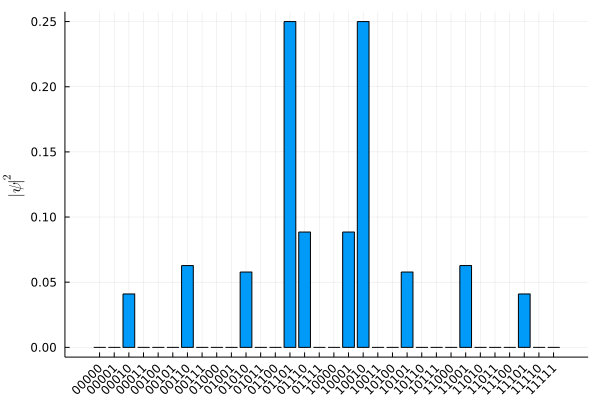

In [11]:
tags = [join(reverse(digits(i, pad=n, base=2))) for i in 0:2^n-1]
bar(tags, abs2.(ψ1), xticks=:all, xrotation=45, ylabel=L"|\psi|^2", legend=false)

In [12]:
# increase number of layers to p = 2

circ2 = Circuit{n}(assemble_time_step_gates(2, n, edges), [Cop])

# gather parameters from circuit
paras = Flux.params(circ2)

# there is not actually any input data for training
data = ncycle([()], 500)

# define optimizer
opt = Descent(0.5)

# define evaluation function
evalcb() = @show(apply(s_uni, circ2))

# perform minimization with the negated target function to achieve maximization
Flux.train!(() -> -apply(s_uni, circ2)[1], paras, data, opt, cb=Flux.throttle(evalcb, 0.5))

apply(s_uni, circ2) = Float32[2.501162]
apply(s_uni, circ2) = Float32[4.9998145]
apply(s_uni, circ2) = Float32[4.999973]
apply(s_uni, circ2) = Float32[4.999996]
apply(s_uni, circ2) = Float32[4.9999986]


In [13]:
# corresponding optimized quantum wavefunction
ψ2 = apply(s_uni, circ2.moments);

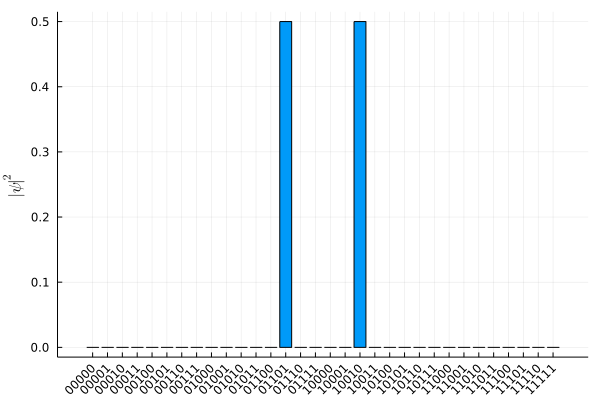

In [14]:
tags = [join(reverse(digits(i, pad=n, base=2))) for i in 0:2^n-1]
bar(tags, abs2.(ψ2), xticks=:all, xrotation=45, ylabel=L"|\psi|^2", legend=false)

Note that there are actually two optimal solutions, $b^{\text{opt}} = 01101$ and $b^{\text{opt}} = 10010$ (since one can swap the role of $\color{blue}{S_0}$ and $\color{green}{S_1}$), which indeed occur with the highest probability.